In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf

import generator
import explainabilityModels

In [3]:
#hyperparameters and blank image and label generation
N = 4000
size = 64
labels = np.random.randint(2, size = N)
imgs = np.zeros((size, size, N))


In [4]:
#fill array with corresponding images
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_blob_img(big = True)
    elif labels[i] == 1:
        x = generator.generate_blob_img(big = False)
    imgs[:,:,i] = x

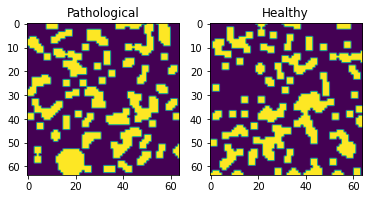

In [10]:
#display one pathological and one healthy image
fig, ax = plt.subplots(1,2)

path_img = imgs[:,:,np.where(labels == 0)[0][0]]
healthy_img = imgs[:,:,np.where(labels ==1)[0][0]]

ax[0].imshow(path_img)
ax[1].imshow(healthy_img)

ax[0].set_title("Pathological");
ax[1].set_title("Healthy");